 # ETL Pipeline for Landing Strip Detection



 This script generates training data for landing strip detection by:

 1. Generating multiple input areas around each landing strip.

 2. Fetching satellite images for these input areas from Google Earth Engine.

 3. Creating label tensors indicating the presence of landing strips.

 4. Saving the images and labels to disk with appropriate naming conventions.



 **Note**: Ensure that you have authenticated with Google Earth Engine (GEE) using `ee.Authenticate()` and have initialized it with `ee.Initialize()`. Also, make sure `train_utils.py` is in your working directory or Python path.

 ## 1. Setup and Imports

In [1]:
# %%
import os
import sys
import random
import logging
from pathlib import Path
import numpy as np
import pandas as pd
import geopandas as gpd
import torch
from shapely.geometry import Polygon
import ee
from tqdm.notebook import tqdm

# Add the src directory to the sys.path if needed
sys.path.append(os.path.abspath('..'))

# Import functions and constants from train_utils
from secret_runway_detection.train_utils import (
    landing_strips_to_enclosing_input_areas,
    input_area_to_input_image,
    input_area_to_has_strip_tensor,
    get_time_period_of_strips_on_area,
    TILE_SIDE_LEN,
    TILES_PER_AREA_LEN,
    INPUT_IMAGE_HEIGHT,
    INPUT_IMAGE_WIDTH,
    RANDOM_SEED,
)


 ## 2. Configuration and Initialization

In [2]:
DEBUG = True

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Set up logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Initialize Earth Engine
ee.Authenticate()
ee.Initialize()

# Set parameters
NUM_INPUT_AREAS_PER_STRIP = 5 if not DEBUG else 1          # Input areas to generate per landing strip

OUTPUT_DIR = Path('../training_data')  # Directory to save the generated data
IMAGE_DIR = OUTPUT_DIR / 'images'
LABEL_DIR = OUTPUT_DIR / 'labels'
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok=True)


 ## 3. Load Landing Strips Data

In [3]:
# %%
# Path to the landing strips shapefile
landing_strips_shp = '../pac_2024_training/pac_2024_training.shp'  # Update this path as needed

# Load the landing strips shapefile
landing_strips = gpd.read_file(landing_strips_shp)

if DEBUG:
    landing_strips = landing_strips.head(10)

# Ensure CRS is WGS84
if landing_strips.crs != 'EPSG:4326':
    landing_strips = landing_strips.to_crs('EPSG:4326')

# Ensure each landing strip has a unique ID
if 'id' not in landing_strips.columns:
    landing_strips['id'] = landing_strips.index

logger.info(f"Loaded {len(landing_strips)} landing strips.")


INFO:__main__:Loaded 10 landing strips.


 ## 4. Generate Input Areas and Fetch Data

In [4]:
# %%
# Create the output directories if they don't exist
os.makedirs(IMAGE_DIR, exist_ok=True)
os.makedirs(LABEL_DIR, exist_ok=True)

# Initialize a counter for area indices
global_area_idx = 0

# Loop over landing strips
for idx, strip in tqdm(landing_strips.iterrows(), total=len(landing_strips), desc="Processing Landing Strips"):
    strip_id = strip['id']
    logger.info(f"Processing landing strip {strip_id}")
    strip_geom = strip.geometry

    # Create a GeoDataFrame with just this strip
    strip_gdf = gpd.GeoDataFrame([strip], crs=landing_strips.crs)

    # Generate NUM_INPUT_AREAS_PER_STRIP input areas for this strip
    for area_idx in range(NUM_INPUT_AREAS_PER_STRIP):
        logger.info(f"Generating input area {area_idx + 1}/{NUM_INPUT_AREAS_PER_STRIP} for landing strip {strip_id}")

        # Generate input area around the strip
        input_areas = landing_strips_to_enclosing_input_areas(
            landing_strips=strip_gdf,
            num_tiles_per_area_side_len=TILES_PER_AREA_LEN,
            tile_side_len=TILE_SIDE_LEN
        )
        input_area = input_areas.iloc[0].geometry  # Get the generated input area

        # Get the time period for the area
        try:
            start_timestamp, end_timestamp = get_time_period_of_strips_on_area(
                strips=strip_gdf,
                area=input_area,
                area_crs=landing_strips.crs
            )
        except ValueError as e:
            logger.warning(f"Skipping area due to error in time period determination: {e}")
            continue

        # Fetch satellite image for the input area
        input_image = input_area_to_input_image(
            input_area=input_area,
            image_data_start_date=start_timestamp,
            image_data_end_date=end_timestamp,
            input_area_crs=landing_strips.crs,
            input_image_width=INPUT_IMAGE_WIDTH,
            input_image_height=INPUT_IMAGE_HEIGHT
        )

        # If the image is empty, skip this area
        if np.all(input_image == 0):
            logger.warning(f"No image data retrieved for area {area_idx} of landing strip {strip_id}. Skipping.")
            continue

        # Create label tensor
        label_tensor = input_area_to_has_strip_tensor(
            landing_strips=landing_strips,
            input_area=input_area,
            input_area_crs=landing_strips.crs,
            tiles_per_area_len=TILES_PER_AREA_LEN
        )

        # Save the image and label
        filename_base = f'area_{global_area_idx}_of_strip_{strip_id}'
        image_filename = IMAGE_DIR / f'{filename_base}.npy'
        label_filename = LABEL_DIR / f'{filename_base}.npy'

        np.save(image_filename, input_image)
        np.save(label_filename, label_tensor.numpy())

        logger.info(f"Saved image and label for area {area_idx} of landing strip {strip_id} as {filename_base}.npy")

        # Increment the global area index
        global_area_idx += 1


Processing Landing Strips:   0%|          | 0/10 [00:00<?, ?it/s]

INFO:__main__:Processing landing strip 1
INFO:__main__:Generating input area 1/1 for landing strip 1
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved image and label for area 0 of landing strip 1 as area_0_of_strip_1.npy
INFO:__main__:Processing landing strip 2
INFO:__main__:Generating input area 1/1 for landing strip 2
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved image and label for area 0 of landing strip 2 as area_1_of_strip_2.npy
INFO:__main__:Processing landing strip 3
INFO:__main__:Generating input area 1/1 for landing strip 3
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Processing landing strip 4
INFO:__main__:Generating input area 1/1 for landing strip 4
INFO:secret_runway_detection.train_utils:Total overlapping areas: 0
INFO:__main__:Saved image and label for area 0 of landing strip 4 as area_2_of_strip_4.npy
INFO:__main__:Processing landing strip 5
INFO:__mai

 ## 5. Visualize Sample Data (Optional)

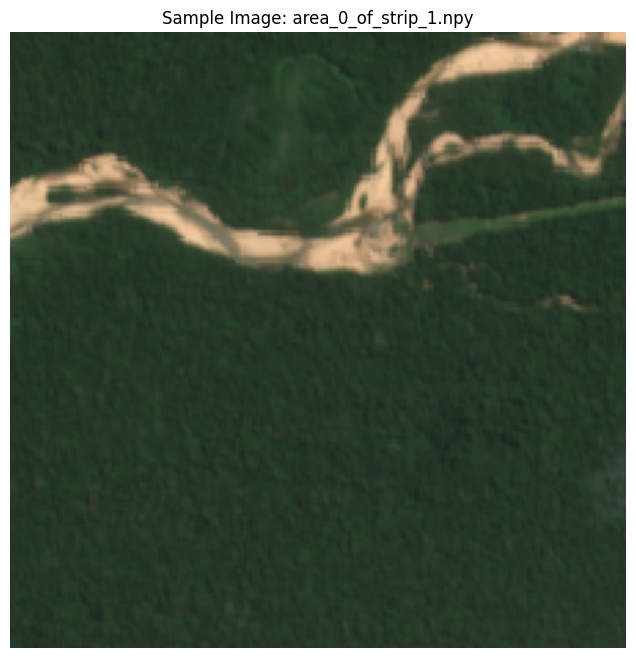

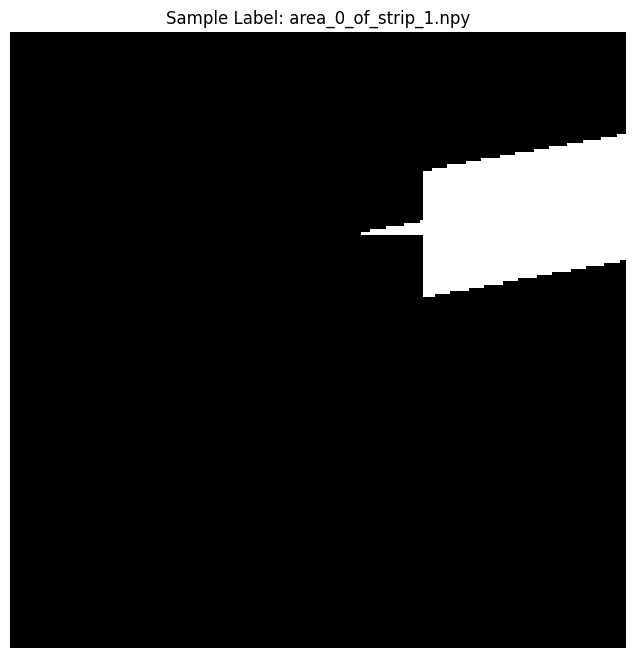

In [5]:
# %%
# (Optional) Code to visualize some of the images and labels
import matplotlib.pyplot as plt

# List all image files
image_files = sorted(IMAGE_DIR.glob('*.npy'))
label_files = sorted(LABEL_DIR.glob('*.npy'))

# Check if there are any files to display
if image_files and label_files:
    # Select a random sample
    sample_idx = random.randint(0, len(image_files) - 1)
    sample_image_path = image_files[sample_idx]
    sample_label_path = label_files[sample_idx]

    # Load the sample image and label
    sample_image = np.load(sample_image_path)
    sample_label = np.load(sample_label_path)

    # Plot the image
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(sample_image, (1, 2, 0)))  # Transpose to (H, W, C)
    plt.title(f'Sample Image: {sample_image_path.name}')
    plt.axis('off')
    plt.show()

    # Plot the label
    plt.figure(figsize=(8, 8))
    plt.imshow(sample_label, cmap='gray')
    plt.title(f'Sample Label: {sample_label_path.name}')
    plt.axis('off')
    plt.show()
else:
    logger.warning("No image or label files found for visualization.")


 ## 6. Summary

In [6]:
# %%
logger.info("ETL process completed. Training data saved to disk.")


INFO:__main__:ETL process completed. Training data saved to disk.
